
<div align="center">
  <img src="https://www.dropbox.com/s/vold2f3fm57qp7g/ECE4179_5179_6179_banner.png?dl=1" alt="ECE4179/5179/6179 Banner" style="max-width: 60%;"/>
</div>

<div align="center">

# Transfer Learning

</div>

Welcome to the eight workshop of ECE4179/5179/6179! In this notebook, we learn about Transfer Learning (TL), a technique that allows us to reuse pre-trained models to solve new problems. In TL, we leverage pre-trained models, trained on large datasets, to tackle new, often smaller, tasks. Instead of starting the learning process from scratch, TL gives us a head start, making it possible to achieve high accuracy with less data and training time. Let's get started!






In [1]:
import os
from copy import deepcopy


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader


from lightning import seed_everything


from torchvision import transforms
from torchvision.utils import make_grid


from torchmetrics import Accuracy


RND_SEED = 42
np.random.seed(RND_SEED)
seed_everything(RND_SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # if CUDA is not working for you
print(device)

Seed set to 42


cuda


<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #1. Understanding a PyTorch model</span>  

When conducting transfer learning or fine-tuning specific layers of a neural network, it's crucial to understand how layers are named and structured within the model. Accessing and modifying particular layers often relies on correctly referencing their names.

As your first task, simply compare the naming conventions of the two models below. 



<details>
<summary style="color: yellow; font-weight: bold;">PyTorch</summary>

In PyTorch, every `nn.Module` contains layers or components that hold learnable parameters, typically weights and biases. The method `named_parameters()` is useful when you want to retrieve both the names and the actual parameters of your model.

Both **linear** and **convolutional** layers have two main types of parameters:
1. **Weights**: These are the core learnable parameters in a layer, responsible for transforming the input.
2. **Biases**: Additional learnable parameters, added to the layer output after applying the weights.

When calling `named_parameters()`, the returned iterable yields:
- `name`: A string that represents the name of the parameter. PyTorch automatically names the parameters following the structure in the model definition.
- `param`: The actual parameter object, which contains the weight values and gradients.


</details>

</div>


In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()

        # Define layers
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.hidden_layer = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        return self.output_layer(x)


# Create an instance of the MLP
mlp1 = MLP(10, 50, 20, 5)

# Print layer names and their corresponding sizes (weights and biases)
for name, param in mlp1.named_parameters():
    print(f"Parameter Name: {name}, Shape: {param.shape}")

# ====================================================================================================
mlp2 = nn.Sequential(
    nn.Linear(10, 50), nn.ReLU(), nn.Linear(50, 20), nn.ReLU(), nn.Linear(20, 5)
)
print(f"*" * 50)
for name, param in mlp2.named_parameters():
    print(f"Parameter Name: {name}, Shape: {param.shape}")

Parameter Name: input_layer.weight, Shape: torch.Size([50, 10])
Parameter Name: input_layer.bias, Shape: torch.Size([50])
Parameter Name: hidden_layer.weight, Shape: torch.Size([20, 50])
Parameter Name: hidden_layer.bias, Shape: torch.Size([20])
Parameter Name: output_layer.weight, Shape: torch.Size([5, 20])
Parameter Name: output_layer.bias, Shape: torch.Size([5])
**************************************************
Parameter Name: 0.weight, Shape: torch.Size([50, 10])
Parameter Name: 0.bias, Shape: torch.Size([50])
Parameter Name: 2.weight, Shape: torch.Size([20, 50])
Parameter Name: 2.bias, Shape: torch.Size([20])
Parameter Name: 4.weight, Shape: torch.Size([5, 20])
Parameter Name: 4.bias, Shape: torch.Size([5])


### Dataset

We will be utilizing the [Butterfly and Moth](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species) dataset available on Kaggle. This dataset comprises images of 100 distinct species of butterflies and moths. Each image is a color JPG file with dimensions $224 \times 224$.

The dataset is divided as follows:
- Training: 12,594 images
- Testing: 500 images (5 per class, ensuring balanced representation)
- Validation: 500 images (similarly balanced with 5 images per species)

It's worth noting that while the test and validation sets maintain class balance, the training set exhibits slight imbalances among species. Given time constraints in the workshop, our exercises will focus on a reduced subset of the training data, with a random selection of 50 images from each species.

In [3]:
# replace the line below with your own path
dataset_path = "data/"

# Get a list of directories (classes) in the train folder
classes = os.listdir(os.path.join(dataset_path, "train"))
classes.sort()  # Optional: sort the class names alphabetically
num_classes = len(classes)


print(f"Number of classes: {num_classes}\n")
print("Classes:")
for i, class_name in enumerate(classes, 1):
    print(f"{i:3}: {class_name}")

Number of classes: 100

Classes:
  1: ADONIS
  2: AFRICAN GIANT SWALLOWTAIL
  3: AMERICAN SNOOT
  4: AN 88
  5: APPOLLO
  6: ARCIGERA FLOWER MOTH
  7: ATALA
  8: ATLAS MOTH
  9: BANDED ORANGE HELICONIAN
 10: BANDED PEACOCK
 11: BANDED TIGER MOTH
 12: BECKERS WHITE
 13: BIRD CHERRY ERMINE MOTH
 14: BLACK HAIRSTREAK
 15: BLUE MORPHO
 16: BLUE SPOTTED CROW
 17: BROOKES BIRDWING
 18: BROWN ARGUS
 19: BROWN SIPROETA
 20: CABBAGE WHITE
 21: CAIRNS BIRDWING
 22: CHALK HILL BLUE
 23: CHECQUERED SKIPPER
 24: CHESTNUT
 25: CINNABAR MOTH
 26: CLEARWING MOTH
 27: CLEOPATRA
 28: CLODIUS PARNASSIAN
 29: CLOUDED SULPHUR
 30: COMET MOTH
 31: COMMON BANDED AWL
 32: COMMON WOOD-NYMPH
 33: COPPER TAIL
 34: CRECENT
 35: CRIMSON PATCH
 36: DANAID EGGFLY
 37: EASTERN COMA
 38: EASTERN DAPPLE WHITE
 39: EASTERN PINE ELFIN
 40: ELBOWED PIERROT
 41: EMPEROR GUM MOTH
 42: GARDEN TIGER MOTH
 43: GIANT LEOPARD MOTH
 44: GLITTERING SAPPHIRE
 45: GOLD BANDED
 46: GREAT EGGFLY
 47: GREAT JAY
 48: GREEN CELLED CATTLE

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #2: Dataset Exploration and Visualization</span>  

Familiarize yourself with the `ButterflyDataset` class and use it to create training, validation, and test datasets. 
Note that we need to use the imagenet transformations for the pre-trained models per what we discussed in the previous workshop. 

To instantiate from the `ButterflyDataset` class, you need to provide the root directory of the data, the transformation to be applied, and the list of classes. For example, if your train folder is located at `dataset_path/train`, you can create the training dataset as follows:

```python

train_dataset = ButterflyDataset("dataset_path/train", 
                                 transform=data_transforms["train"],
                                 classes=classes)
```


**Instructions:**

1. **Dataset Creation**:
   - Instantiate training, validation, and test datasets using the `ButterflyDataset` class. Make sure to apply the respective transformations provided in the `data_transforms` dictionary.
   
   
2. **Data Loaders**:
   - Construct data loaders for the datasets you've just created. Consider using `torch.utils.data.DataLoader`. Choose a reasonable batch size that aligns with the computational resources available to you.

3. **Sanity Check**:
   - Print out the length of each dataset (training, validation, test) to ensure your data has been loaded correctly.

4. **Visualization**:
   - Use the `imshow` function provided to visualize some images from each set. This will give you a feel for the data's appearance after transformations and also validate the correctness of your data loaders.



In [5]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


# image dataset class
class ButterflyDataset(Dataset):
    def __init__(self, root_dir, transform=None, classes=None):
        super().__init__()

        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.data = []

        # Gather all image paths and corresponding labels
        for label, label_id in zip(self.classes, range(len(self.classes))):
            label_dir = os.path.join(self.root_dir, label)
            for filename in os.listdir(label_dir):
                if filename.endswith(".jpg"):
                    image_path = os.path.join(label_dir, filename)
                    self.data.append((image_path, label_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_dataset = ButterflyDataset(
    os.path.join(dataset_path, "train"),
    transform=data_transforms["train"],
    classes=classes,
)
test_dataset = ButterflyDataset(
    os.path.join(dataset_path, "test"),
    transform=data_transforms["test"],
    classes=classes,
)
val_dataset = ButterflyDataset(
    os.path.join(dataset_path, "valid"),
    transform=data_transforms["test"],
    classes=classes,
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 5000
Test dataset size: 500
Validation dataset size: 500


In [7]:
# dataloaders
batch_size = 64

trn_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tst_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

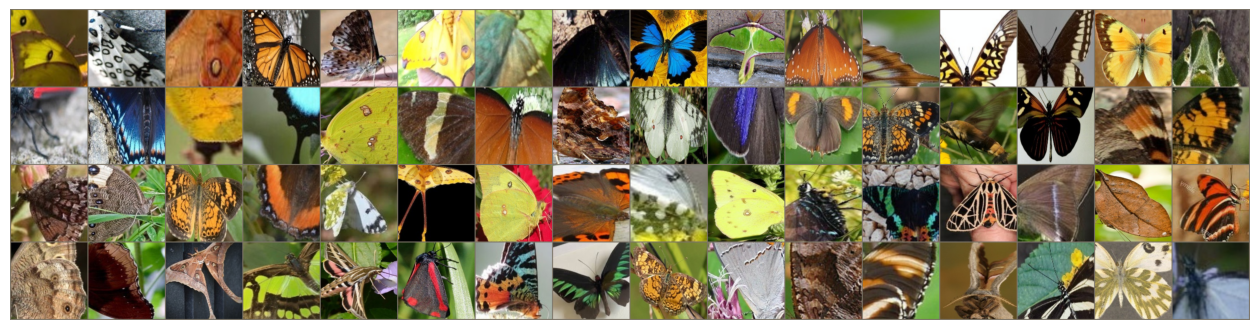

In [8]:
def imshow(inp, title=None):
    """Display an image from a Tensor.

    Args:
        inp (Tensor): The input image tensor in the format (C, H, W),
                      typically obtained from the dataloader.
        title (str, optional): Optional title for the image plot.
    """
    # Convert the input tensor to a NumPy array and transpose it to (H, W, C) for display
    inp = inp.numpy().transpose((1, 2, 0))

    # Mean and standard deviation used during the normalization of ImageNet pre-trained models
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # the input is a normalized tensor, we need to reverse the normalization process (multiply by std and add mean)
    inp = std * inp + mean

    # Clip values to ensure they are within the range [0, 1], suitable for displaying images
    inp = np.clip(inp, 0, 1)

    # Display the image using matplotlib
    plt.imshow(inp)

    # If a title is provided, display it
    if title is not None:
        plt.title(title)

    # Remove axis labels and ticks for a cleaner image display
    plt.axis("off")


imgs, y = next(
    iter(trn_loader)
)  # Get a batch of images and labels from the train dataloader

# Make a grid of images from the batch using torchvision's make_grid function
# `nrow=16` means there will be 8 images per row, and `padding=3` adds space between images
out = make_grid(imgs, nrow=16, padding=3)

# Plot the images in a larger figure to improve visibility
plt.figure(figsize=(16, 12))  # Set the size of the figure
imshow(out)  # Display the grid of images using the imshow function

To help you get started, we've provided two functions to evaluate and train a model. Familiarize yourself with these functions as you will be using them throughout the workshop. Note that we opt for pure PyTorch training loops (as Mehrtash is too lazy to use Lightning) to keep things simple and easy to follow. 


In [9]:
def evaluate_model(data_loader, model=None):
    # Ensure that a model is provided for evaluation
    if model is None:
        raise ValueError("model is None")

    # Initialize the Accuracy metric for multiclass classification
    # `Accuracy` will compute the accuracy of the predictions with respect to labels
    # `classes` should be a list of the unique class names
    accuracy = Accuracy(task="multiclass", num_classes=len(classes)).to(device)

    # Define the criterion (loss function) as Cross Entropy Loss
    # This is commonly used for multiclass classification tasks
    criterion = nn.CrossEntropyLoss()

    # Set the model to evaluation mode. In this mode, certain layers like Dropout
    # and BatchNorm will behave differently than in training mode.
    model.eval()

    # Initialize counters for total loss and accuracy
    total_loss = 0.0
    total_accuracy = 0.0

    # `torch.inference_mode()` disables gradient computation during the loop,
    # which reduces memory usage and speeds up the computations
    with torch.inference_mode():
        # Iterate over the batches of data in the data loader
        for images, labels in data_loader:
            # Move the images and labels to the GPU (or specified device)
            images = images.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)
            # Accumulate the batch loss into the total loss
            total_loss += loss.item()

            # Convert model outputs to predicted class indices
            preds = torch.argmax(outputs, dim=1)
            # Update the accuracy metric with predictions and actual labels
            accuracy.update(preds, labels)

    # Calculate the average loss over all batches
    total_loss /= len(data_loader)
    # Compute the overall accuracy
    total_accuracy = accuracy.compute().item()

    return total_loss, total_accuracy

In [10]:
def train_model(model=None, lr=0.001, num_epochs=5):
    # Ensure that a model is provided for training
    if model is None:
        raise ValueError("model is None")

    # Define the loss function as Cross Entropy Loss
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer as Adam with the provided learning rate `lr`
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values for each epoch
    train_losses = []
    val_losses = []
    val_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training loop for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        total_loss = 0.0

        # Iterate over the batches of data in the training data loader
        for images, labels in trn_loader:
            # Move images and labels to the GPU (or specified device)
            images = images.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # Compute the loss between predicted and actual labels
            loss = criterion(outputs, labels)

            # Zero the gradients to ensure that they aren't accumulated across epochs
            optimizer.zero_grad()
            # Perform the backward pass to compute gradients
            loss.backward()
            # Update the model's weights
            optimizer.step()

            # Accumulate the batch loss
            total_loss += loss.item()

        # Compute the average training loss for the epoch
        avg_loss = total_loss / len(trn_loader)
        train_losses.append(avg_loss)

        # Evaluate the model on validation data
        val_loss, val_acc = evaluate_model(val_loader, model)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Evaluate the model on test data
        tst_loss, tst_acc = evaluate_model(tst_loader, model)
        test_losses.append(tst_loss)
        test_accuracies.append(tst_acc)

        # Print training progress
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        print(f"Test Loss: {tst_loss:.4f}, Test Accuracy: {tst_acc:.4f}")
        print("======================================")

    # Create a dictionary to hold results
    results_dict = {
        "train_loss": avg_loss,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "test_loss": tst_loss,
        "test_accuracy": tst_acc,
    }

    return results_dict

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #3: ResNet18 as pre-trained model</span>

We will employ the ResNet18 model, pre-trained on the ImageNet dataset, in this workshop. Use the PyTorch Hub to load the model and print out its layers and parameters. This will give you a sense of the model's architecture and the dimensionality of its weights.


There are a couple of things to note here:
- the model has four main convolutional blocks. The number of filters increases from 64 to 512 as we go deeper into the network.

- at the start of each convolutional block, we have a downsampling layer that reduces the spatial dimensions of the input by a factor of 2. This is achieved by a convolutional layer with stride 2.

- the last layer of the model is a fully-connected layer with 512 input features and 1000 output features. This layer is responsible for mapping the features extracted by the convolutional layers to the 1000 ImageNet classes.

- Inside each block, the input of the block is added similar to the residual connections to the output of middle convolutional layer. Since the number of channels of the input and output of the block are different, the input is first passed through a 1x1 convolutional layer to match the number of channels of the output. This is called the projection shortcut. 

</div>

In [11]:
import torchvision

# We will keep this for later
model0 = torchvision.models.resnet18(pretrained=True)


for name, param in model0.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")

/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lucas/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.4MB/s]

Name: conv1.weight, Shape: torch.Size([64, 3, 7, 7])
Name: bn1.weight, Shape: torch.Size([64])
Name: bn1.bias, Shape: torch.Size([64])
Name: layer1.0.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.0.bn1.weight, Shape: torch.Size([64])
Name: layer1.0.bn1.bias, Shape: torch.Size([64])
Name: layer1.0.conv2.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.0.bn2.weight, Shape: torch.Size([64])
Name: layer1.0.bn2.bias, Shape: torch.Size([64])
Name: layer1.1.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.1.bn1.weight, Shape: torch.Size([64])
Name: layer1.1.bn1.bias, Shape: torch.Size([64])
Name: layer1.1.conv2.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.1.bn2.weight, Shape: torch.Size([64])
Name: layer1.1.bn2.bias, Shape: torch.Size([64])
Name: layer2.0.conv1.weight, Shape: torch.Size([128, 64, 3, 3])
Name: layer2.0.bn1.weight, Shape: torch.Size([128])
Name: layer2.0.bn1.bias, Shape: torch.Size([128])
Name: layer2.0.conv2.weight, Shape: torch.Size(

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">


### <span style="color: pink;">Task #4. Linear Probing</span>  

Linear probing is a technique in transfer learning where we leverage the features learned by a pre-trained model by just replacing the classifier of the pre-trained model with a single linear layer and learning only the parameters of the linear layer. The idea is to benefit directly from the representational power of the fixed, pre-trained model. A good performance by linear probing indicates that the extracted features by the pre-trained model are rich and discriminative for the given task. To implement linear probing, these steps are typically followed:

1. Use a pre-trained model and remove its classification layer. This truncated model will serve as our feature extractor.

2. On top of this, add a new linear layer that corresponds to the number of classes in your task.

3. Train only this linear layer using your dataset while keeping the rest of the model frozen.

Here is some Python/PyTorch hints to get you going:

```python

# use deepcopy from the copy module to avoid modifying the original model
model = copy.deepcopy(pretrained_model)

# find the name of the last layer of the model
# you can use print(model) to see the structure of the model


# imagine the name of the last layer is "fc"
# you can replace the last layer with a new layer as follows
model.fc = nn.Linear(in_features=..., out_features=...)

# now you need to freeze the rest of the model from getting updated
# you can do this by setting the requires_grad attribute of the parameters to False
# you can use the following code snippet to do this
for name, param in model.parameters():
    if 'fc' in name: # unfreeze the last fully-connected
        param.requires_grad = True
    else: # freeze all other parameters
        param.requires_grad = False
```
Note that ResNets use batchnorm layers, helping them to generalize better. Batchnorm layers have learnable parameters and also running mean and variance. In transfer learning, we usually freeze the batchnorm layers to avoid updating their running mean and variance. This can be done via the following code snippet:

```python   
# Set BN layers to eval mode to freeze running mean/variance
for module in model.modules():
    if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
        module.eval()  # This will freeze the running statistics of the BN layers

```

I will let you explore whether freezing the batchnorm layers is beneficial or not in this task.

<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">85.8%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">84.0%</span>.
</details>


</div>


In [12]:
# add your code below. Define the number of epochs to train for based on your laptop's performance
# on a CPU, my machine takes about 2 minutes per epoch
num_epochs = 10

# Create a new model from the pretrained one
model1 = deepcopy(model0)  # <--- study the code here

# Change the last layer to output 100 classes
model1.fc = nn.Linear(512, 100)

# Freeze all layers except the last fully-connected
for name, param in model1.named_parameters():
    if "fc" in name:  # unfreeze the last fully-connected
        param.requires_grad = True
    else:  # freeze all other parameters
        param.requires_grad = False

model1 = model1.to(device)

# Train the model
res1 = train_model(model=model1, num_epochs=num_epochs)

Epoch [1/10]
Training Loss: 3.8522
Validation Loss: 2.8465, Validation Accuracy: 0.4280
Test Loss: 2.8614, Test Accuracy: 0.4340
Epoch [2/10]
Training Loss: 2.3556
Validation Loss: 1.9131, Validation Accuracy: 0.6460
Test Loss: 1.9279, Test Accuracy: 0.6520
Epoch [3/10]
Training Loss: 1.7015
Validation Loss: 1.4108, Validation Accuracy: 0.7280
Test Loss: 1.4129, Test Accuracy: 0.7400
Epoch [4/10]
Training Loss: 1.3552
Validation Loss: 1.1831, Validation Accuracy: 0.7660
Test Loss: 1.1783, Test Accuracy: 0.7780
Epoch [5/10]
Training Loss: 1.1633
Validation Loss: 1.0491, Validation Accuracy: 0.7880
Test Loss: 1.0429, Test Accuracy: 0.7900
Epoch [6/10]
Training Loss: 1.0152
Validation Loss: 0.9742, Validation Accuracy: 0.8040
Test Loss: 0.9571, Test Accuracy: 0.7740
Epoch [7/10]
Training Loss: 0.9660
Validation Loss: 0.9201, Validation Accuracy: 0.7980
Test Loss: 0.8833, Test Accuracy: 0.7980
Epoch [8/10]
Training Loss: 0.8700
Validation Loss: 0.8650, Validation Accuracy: 0.8100
Test Loss

### Fine-tuning the last convolutional block of a pre-trained model

In linear probing, we merely adjusted the classifier (last fully-connected layer) of the model. Fine-tuning the convolutional blocks allows us to harness the power of pre-trained models even further.

A pre-trained model has already learned a significant amount of information from data, especially in the initial layers. The initial layers of a model often capture generic features.For example, a CNN trained on ImageNet will learn to detect features like edges, textures, and primitive shapes in its initial convolutional layers. As we move deeper into the model, the layers tend to capture more dataset-specific or task-specific features. By fine-tuning the last convolutional layer(s), we aim to adjust these deeper features to better suit our specific task.

**Why Fine-tune the Last Convolutional Layer?**

1. **Better Feature Representation**: The final layers usually represent high-level features. Adjusting them can lead to better feature representations for our specific task.

2. **Faster Training**: Since we are adjusting only the last few layers, the training process is faster than training from scratch.
  
3. **Avoid Overfitting**: Fine-tuning a few layers (instead of the entire model) reduces the number of trainable parameters, potentially reducing the risk of overfitting, especially when our dataset is not very large.

**How to Do It?**
1. First, you'll want to identify the last convolutional layer or block in your model. This might vary depending on the architecture.
2. Once identified, set `requires_grad=True` for its parameters, allowing them to be updated during training.
3. Train the model for a few epochs and observe the results. If the model is overfitting, you can try reducing the learning rate.

Remember, the idea is not to start from scratch but to leverage the knowledge already present in the model and adapt it to our specific task.


<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">


### <span style="color: pink;">Task #5. Fine-tune convolutional block 4 and the classifier</span>

ResNet18 has 4 convolutional blocks. Each convoltional block has two convolutional layers. In this task, you will fine-tune the last convolutional block and the classifier. 



<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">90.2%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">91.2%</span>.

</details>


</div>

In [13]:
model2 = deepcopy(model1)  # <--- add your code here


# freeze all parameters except the last fc layer (classifier)
# and the conv layers in the last block (layer4)
# add your code below
for name, param in model2.named_parameters():
    # <--- add your code here
    if "layer2.1.conv1" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


model2 = model2.to(device)

# Train the model
res2 = train_model(model=model2, num_epochs=num_epochs)

Epoch [1/10]
Training Loss: 0.7227
Validation Loss: 0.6779, Validation Accuracy: 0.8260
Test Loss: 0.6139, Test Accuracy: 0.8460
Epoch [2/10]
Training Loss: 0.5967
Validation Loss: 0.5940, Validation Accuracy: 0.8620
Test Loss: 0.5763, Test Accuracy: 0.8460
Epoch [3/10]
Training Loss: 0.5868
Validation Loss: 0.6000, Validation Accuracy: 0.8420
Test Loss: 0.5378, Test Accuracy: 0.8500
Epoch [4/10]
Training Loss: 0.5368
Validation Loss: 0.5350, Validation Accuracy: 0.8740
Test Loss: 0.4965, Test Accuracy: 0.8560
Epoch [5/10]
Training Loss: 0.5128
Validation Loss: 0.5658, Validation Accuracy: 0.8580
Test Loss: 0.4899, Test Accuracy: 0.8780
Epoch [6/10]
Training Loss: 0.4882
Validation Loss: 0.5530, Validation Accuracy: 0.8480
Test Loss: 0.4696, Test Accuracy: 0.8700
Epoch [7/10]
Training Loss: 0.4842
Validation Loss: 0.5355, Validation Accuracy: 0.8600
Test Loss: 0.4731, Test Accuracy: 0.8780
Epoch [8/10]
Training Loss: 0.4478
Validation Loss: 0.4855, Validation Accuracy: 0.8740
Test Loss

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">


### <span style="color: pink;">Task #6. Question everything! </span>
Just to gain a better understanding, let's try to fine-tune the first convolutional block of ResNet18. What do you expect to happen? Will the model perform better or worse? Why? In terms of training time, do you expect it to be faster or slower? Why?


<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">83.6%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">83.8%</span>.

</details>


</div>

In [14]:
import re

model3 = deepcopy(model2)  # <--- add your code here


# freeze all parameters except the last fc layer (classifier)
# and the conv layers in the first block (layer1)
# add your code below
for name, param in model3.named_parameters():
    # <--- add your code here
    if re.search("^layer1.*conv", name) or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model3 = model3.to(device)

# Train the model
res3 = train_model(model=model3, num_epochs=num_epochs)

Epoch [1/10]
Training Loss: 0.4858
Validation Loss: 0.5814, Validation Accuracy: 0.8440
Test Loss: 0.4778, Test Accuracy: 0.8520
Epoch [2/10]
Training Loss: 0.4533
Validation Loss: 0.5964, Validation Accuracy: 0.8320
Test Loss: 0.5266, Test Accuracy: 0.8400
Epoch [3/10]
Training Loss: 0.4599
Validation Loss: 0.5219, Validation Accuracy: 0.8500
Test Loss: 0.4353, Test Accuracy: 0.8640
Epoch [4/10]
Training Loss: 0.4637
Validation Loss: 0.5848, Validation Accuracy: 0.8340
Test Loss: 0.5050, Test Accuracy: 0.8560
Epoch [5/10]
Training Loss: 0.4477
Validation Loss: 0.5190, Validation Accuracy: 0.8660
Test Loss: 0.4357, Test Accuracy: 0.8640
Epoch [6/10]
Training Loss: 0.4195
Validation Loss: 0.4761, Validation Accuracy: 0.8780
Test Loss: 0.3978, Test Accuracy: 0.8860
Epoch [7/10]
Training Loss: 0.3884
Validation Loss: 0.5675, Validation Accuracy: 0.8380
Test Loss: 0.4845, Test Accuracy: 0.8540
Epoch [8/10]
Training Loss: 0.4182
Validation Loss: 0.5063, Validation Accuracy: 0.8680
Test Loss

### Progressive Fine-Tuning

Progressive fine-tuning is an intuitive and gradual adaptation strategy for fine-tuning pre-trained models. Instead of immediately adjusting all the layers or a specific subset, we progressively unfreeze and fine-tune the layers starting from the top (final layers) and moving towards the bottom (initial layers).

**Why Use Progressive Fine-Tuning?**
There are two main reasons to use progressive fine-tuning:

- **Reduce Overfitting**: Gradually training layers reduces the risk of overfitting, especially when the target dataset is small.
  
- **Stable Convergence**: It often results in more stable convergence during training. Immediate unfreezing of all layers can sometimes lead to catastrophic forgetting of useful features.

**Steps for Progressive Fine-Tuning**:
1. **Start Frozen**: Begin with all layers frozen except the final classification layer. Train until convergence or for a few epochs.
2. **Unfreeze Gradually**: Start unfreezing the last layers progressively. For instance, you can unfreeze the last convolutional block and fine-tune.
3. **Iterate**: Continue this process, moving deeper into the network, unfreezing more blocks or layers as you go. After each unfreezing step, train the model for a few epochs.

There are various strategies for progressive fine-tuning, and one approach is as follows:

1. **Initial Training**: Start by training only the final classification layer, keeping all other layers frozen.
   
2. **Fine-Tune Convolutional Blocks**: Once the classification layer has been trained, freeze it. Proceed to unfreeze and fine-tune the last convolutional block(s).
   
3. **Re-Train Classification Layer**: After fine-tuning the convolutional block(s), unfreeze the classification layer. Train both the classification layer and the last convolutional block(s) simultaneously.
   


<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px;">
 
### <span style="color: pink;">Task #7. Progressive Fine-Tuning</span>

We will take a simple approach to progressive fine-tuning. We will start with the linear probing model and then fine-tune the last convolutional block along with the classifier.


<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">88.6%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">91.4%</span>.

</details>


</div>

In [ ]:
# add your code below
model4 = deepcopy() # model1 is the one with the last fc layer unfrozen


# freeze all parameters except the last fc layer (classifier)
# and the conv layers in the last block (layer4)
# add your code below
for name, param in model4.named_parameters():
    # <--- add your code here

model4 = model4.to(device)

# Train the model
res4 = train_model(model=model4, num_epochs=num_epochs, lr=# <--- add your code here)

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">


### <span style="color: pink;">Task #8. MLP as Classifier in Transfer Learning</span>  


When employing transfer learning, one common practice is to replace the final fully connected layer (or linear probing layer) of the pre-trained model with a new classifier tailored to the new task. While a single linear layer is frequently used for this purpose, a more expressive MLP can be beneficial for complex tasks that require higher capacity.

Your Task:

1. Remove the last fully connected layer from the pre-trained model.
2. Append a two-layer MLP with 256 hidden units to the model.
3. Fine-tune this new structure on the dataset.

To implement the MLP, you can use the following code snippet:

```python
mlp = nn.Sequential(
    nn.Linear(in_features=..., out_features=...),
    nn.ReLU(),
    nn.Linear(in_features=..., out_features=...),
)

# Then you can append the MLP to the model as follows
model.fc = mlp
```



You may want to use a dropout layer to prevent overfitting. 


<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">85.0%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">87.2%</span>.

</details>


</div>

In [ ]:
# we start with the pretrained model
model5 = deepcopy(model0)

# replace the last fc layer with an MLP
# add your code below
model5.fc = nn.Sequential(
    # <--- add your code here
)


model5 = model5.to(device)
res5 = train_model(model=model5, num_epochs=num_epochs)

<div style="padding-top: 10cm;"></div>

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">


### Fine-tuning a Self-Supervised Model

</div>

Self-supervised learning (SSL) is to train models without the need for labeled data. Unlike conventional supervised models that rely on large amounts of labeled data, SSL models learn powerful representations by predicting certain aspects of the data itself.

Key Differences:
- **Learning Approach**: SSL models predict parts of the input, like masked portions or augmentations, rather than explicit class labels.
- **Robust Representations**: SSL often leads to more generalized and robust feature representations, beneficial in scarce labeled data scenarios.

[**DINO (DIstillation with NO Labels)**](https://dinov2.metademolab.com/) is a prominent SSL technique. Instead of using class labels, DINO optimizes the model to produce consistent embeddings for different augmentations of the same image. These embeddings capture rich semantic information. Below, we will use a pre-trained DINO model and fine-tune it for our butterfly classification task. We will use DINO-ResNet50 model but you can use any other DINO-V2 models (all are transformer-based) from HuggingFace for the fun of it.


<details>
<summary style="color: yellow; font-weight: bold;">Show me some results</summary>
After training this model for 20 epochs, you can expect a validation accuracy of around <span style="background-color: #ADD8E6">88.6%</span>. Correspondingly, the test accuracy for that model would be <span style="background-color: #ADD8E6">89.8%</span>.

</details>




In [ ]:
# The DINO model is available in the PyTorch Hub
ssl_model = torch.hub.load("facebookresearch/dino:main", "dino_resnet50")

print(ssl_model)

In [ ]:
ssl_model.fc = nn.Linear(2048, num_classes)
print(ssl_model)

In [ ]:
for name, param in ssl_model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

ssl_model = ssl_model.to(device)
res_ssl = train_model(model=ssl_model, num_epochs=num_epochs)